In [1]:
from pathlib import Path
RAW_DIR = Path("data")

In [2]:
# 셀 2: 공통 import 및 전역 설정

from __future__ import annotations
from pathlib import Path
from typing import List, Optional, Dict

import numpy as np
import pandas as pd

# 스냅샷 생성 시점 (마감 7/3/1/0일 전)
SNAPSHOT_OFFSETS_DAYS: List[int] = [7, 3, 1, 0]
# 48시간 경고 라벨 기준
WARN_HOURS: int = 48


In [7]:
# 셀 2: 전체 파이프라인 코드 (VLE 클릭 기반 feature 제거 버전)

from __future__ import annotations
from pathlib import Path
from typing import List, Optional, Dict

import numpy as np
import pandas as pd

# -----------------------------
# 전역 설정
# -----------------------------
SNAPSHOT_OFFSETS_DAYS: List[int] = [7, 3, 1, 0]   # 마감 7/3/1/0일 전 스냅샷
WARN_HOURS: int = 48                               # 48시간 경고 라벨용


# -----------------------------
# 1. RAW 데이터 로딩
# -----------------------------
def load_oulad(raw_dir: Path,
               modules: Optional[List[str]] = None,
               presentations: Optional[List[str]] = None
               ) -> Dict[str, pd.DataFrame]:
    """
    OULAD 원본 CSV 로딩.
    ▶ 클릭 기반 feature는 안 쓰므로 studentVle는 읽지 않음.
    """
    raw_dir = Path(raw_dir)

    assessments = pd.read_csv(raw_dir / "assessments.csv")
    student_assessment = pd.read_csv(raw_dir / "studentAssessment.csv")
    student_reg = pd.read_csv(raw_dir / "studentRegistration.csv")
    student_info = pd.read_csv(raw_dir / "studentInfo.csv")

    if modules is not None:
        assessments = assessments[assessments["code_module"].isin(modules)]
        student_reg = student_reg[student_reg["code_module"].isin(modules)]
        student_info = student_info[student_info["code_module"].isin(modules)]

    if presentations is not None:
        assessments = assessments[assessments["code_presentation"].isin(presentations)]
        student_reg = student_reg[student_reg["code_presentation"].isin(presentations)]
        student_info = student_info[student_info["code_presentation"].isin(presentations)]

    return {
        "assessments": assessments,
        "student_assessment": student_assessment,
        "student_reg": student_reg,
        "student_info": student_info,
    }


# -----------------------------
# 2. 기본 테이블 전처리
# -----------------------------
def prepare_assessments(assessments: pd.DataFrame) -> pd.DataFrame:
    df = assessments.copy()

    df["course_id"] = df["code_module"] + "_" + df["code_presentation"]

    df = df.rename(columns={
        "id_assessment": "task_id",
        "assessment_type": "task_type",
        "date": "due_day",
    })

    before = len(df)
    df = df[np.isfinite(df["due_day"])].copy()
    after = len(df)
    dropped = before - after
    if dropped > 0:
        print(f"[prepare_assessments] dropped {dropped} assessments with missing due_day")

    df["weight"] = df["weight"].fillna(0.0)
    df["weight_frac"] = df["weight"] / 100.0
    df["due_day"] = df["due_day"].astype(int)

    return df[[
        "course_id", "code_module", "code_presentation",
        "task_id", "task_type", "due_day", "weight", "weight_frac"
    ]]


def prepare_registrations(student_reg: pd.DataFrame) -> pd.DataFrame:
    df = student_reg.copy()
    df["course_id"] = df["code_module"] + "_" + df["code_presentation"]
    df = df.rename(columns={"id_student": "student_id"})
    return df[["course_id", "student_id", "date_registration", "date_unregistration"]]


def prepare_student_assessment(student_assessment: pd.DataFrame,
                               assessments_pre: pd.DataFrame) -> pd.DataFrame:
    sa = student_assessment.copy().rename(columns={
        "id_student": "student_id",
        "id_assessment": "task_id",
        "date_submitted": "submission_day"
    })

    sa = sa.merge(
        assessments_pre[["course_id", "task_id", "due_day", "weight_frac"]],
        on="task_id",
        how="left"
    )

    sa["submitted_final"] = sa["submission_day"].notna()

    sa["late_final"] = np.where(
        sa["submitted_final"],
        sa["submission_day"] > sa["due_day"],
        True,   # 미제출 = late로 간주
    )

    sa["buffer_days"] = np.where(
        sa["submitted_final"],
        sa["due_day"] - sa["submission_day"],
        np.nan
    )

    return sa[[
        "course_id", "student_id", "task_id",
        "due_day", "submission_day",
        "submitted_final", "late_final", "buffer_days",
        "weight_frac", "score", "is_banked"
    ]]


def prepare_student_info(student_info: pd.DataFrame) -> pd.DataFrame:
    """
    studentInfo.csv에서 static feature 일부만 사용.
    👉 disability, final_result는 제외
    """
    si = student_info.copy().rename(columns={"id_student": "student_id"})
    si["course_id"] = si["code_module"] + "_" + si["code_presentation"]

    # disability, final_result 제거
    return si[[
        "course_id", "student_id",
        "gender", "age_band", "highest_education",
        "studied_credits"
    ]]



# -----------------------------
# 3. 스냅샷 생성 + 학생 붙이기 + 라벨링
# -----------------------------
def build_assessment_snapshots(assessments_pre: pd.DataFrame,
                               snapshot_offsets: List[int]) -> pd.DataFrame:
    offsets_df = pd.DataFrame({"offset_days": snapshot_offsets})

    a = assessments_pre[["course_id", "task_id", "due_day"]].copy()
    a["key"] = 1
    offsets_df["key"] = 1
    cross = a.merge(offsets_df, on="key").drop(columns="key")

    cross["snapshot_day"] = cross["due_day"] - cross["offset_days"]
    cross = cross[cross["snapshot_day"] >= 0].copy()

    cross["time_to_deadline_days"] = cross["offset_days"]
    cross["time_to_deadline_hours"] = cross["time_to_deadline_days"] * 24

    return cross[[
        "course_id", "task_id", "snapshot_day",
        "time_to_deadline_days", "time_to_deadline_hours",
        "due_day"
    ]]


def attach_students_to_snapshots(snapshots_task: pd.DataFrame,
                                 registrations: pd.DataFrame) -> pd.DataFrame:
    students = registrations[["course_id", "student_id"]].drop_duplicates()
    snapshots = snapshots_task.merge(students, on="course_id", how="inner")

    snapshots["snapshot_id"] = (
        snapshots["student_id"].astype(str) + "_" +
        snapshots["task_id"].astype(str) + "_" +
        snapshots["snapshot_day"].astype(str)
    )
    return snapshots


def add_labels_and_submission_status(snapshots: pd.DataFrame,
                                     sa_pre: pd.DataFrame) -> pd.DataFrame:
    df = snapshots.merge(
        sa_pre[["course_id", "student_id", "task_id",
                "due_day", "submission_day",
                "submitted_final", "late_final"]],
        on=["course_id", "student_id", "task_id"],
        how="left"
    )

    df["submitted_final"] = df["submitted_final"].fillna(False)
    df["late_final"] = df["late_final"].fillna(True)

    df["submitted_by_snapshot"] = np.where(
        df["submitted_final"] & df["submission_day"].notna(),
        df["submission_day"] <= df["snapshot_day"],
        False
    )

    df["label_late_final"] = df["late_final"].astype(int)

    warn_days = WARN_HOURS / 24.0
    df["label_warn_H48"] = np.where(
        (df["time_to_deadline_days"] <= warn_days) &
        (~df["submitted_by_snapshot"]) &
        (df["late_final"]),
        1,
        0
    )

    return df


# -----------------------------
# 4. 과거 과제 히스토리 feature
# -----------------------------
def build_past_assessment_history(sa_pre: pd.DataFrame) -> pd.DataFrame:
    daily = (
        sa_pre.groupby(["course_id", "student_id", "due_day"], as_index=False)
              .agg(
                  tasks_on_day=("task_id", "count"),
                  late_on_day=("late_final", lambda x: x.sum()),
                  submitted_on_day=("submitted_final", lambda x: x.sum()),
                  buffer_sum_on_day=("buffer_days", lambda x: np.nansum(x))
              )
              .rename(columns={"due_day": "day"})
              .sort_values(["course_id", "student_id", "day"])
    )
    daily["day"] = daily["day"].astype("int64")

    daily["cum_tasks"] = daily.groupby(["course_id", "student_id"])["tasks_on_day"].cumsum()
    daily["cum_late"] = daily.groupby(["course_id", "student_id"])["late_on_day"].cumsum()
    daily["cum_submitted"] = daily.groupby(["course_id", "student_id"])["submitted_on_day"].cumsum()
    daily["cum_buffer_sum"] = daily.groupby(["course_id", "student_id"])["buffer_sum_on_day"].cumsum()

    return daily


def add_past_history_features(snapshots: pd.DataFrame,
                              history_daily: pd.DataFrame) -> pd.DataFrame:
    df = snapshots.copy()
    df["history_day"] = df["snapshot_day"] - 1
    df["history_day"] = df["history_day"].astype("int64")

    hist = history_daily.copy()
    hist["day"] = hist["day"].astype("int64")

    merged = pd.merge_asof(
        df.sort_values("history_day"),
        history_daily.sort_values("day"),
        left_on="history_day",
        right_on="day",
        by=["course_id", "student_id"],
        direction="backward"
    )

    for col in ["cum_tasks", "cum_late", "cum_submitted", "cum_buffer_sum"]:
        merged[col] = merged[col].fillna(0.0)

    merged["past_num_tasks"] = merged["cum_tasks"]
    merged["past_late_ratio"] = np.where(
        merged["cum_tasks"] > 0,
        merged["cum_late"] / merged["cum_tasks"],
        0.0
    )
    merged["past_avg_buffer_days"] = np.where(
        merged["cum_submitted"] > 0,
        merged["cum_buffer_sum"] / merged["cum_submitted"],
        0.0
    )

    return merged


# -----------------------------
# 5. 앞으로의 workload feature
# -----------------------------
def add_workload_features(snapshots: pd.DataFrame,
                          assessments_pre: pd.DataFrame,
                          horizons_days: List[int] = [3, 7]) -> pd.DataFrame:
    df = snapshots.copy()
    unique_cd = df[["course_id", "snapshot_day"]].drop_duplicates()

    rows = []
    for course_id, grp in unique_cd.groupby("course_id"):
        due_days = assessments_pre.loc[assessments_pre["course_id"] == course_id, "due_day"].values
        if len(due_days) == 0:
            continue
        for snapshot_day in grp["snapshot_day"]:
            row = {"course_id": course_id, "snapshot_day": snapshot_day}
            for h in horizons_days:
                mask = (due_days > snapshot_day) & (due_days <= snapshot_day + h)
                row[f"num_tasks_due_next_{h}d"] = int(mask.sum())
            rows.append(row)

    workload = pd.DataFrame(rows)
    df = df.merge(workload, on=["course_id", "snapshot_day"], how="left")

    for h in horizons_days:
        col = f"num_tasks_due_next_{h}d"
        df[col] = df[col].fillna(0).astype(int)

    return df


# -----------------------------
# 6. studentInfo static feature
# -----------------------------
def add_student_static_features(snapshots: pd.DataFrame,
                                student_info_pre: pd.DataFrame) -> pd.DataFrame:
    df = snapshots.merge(
        student_info_pre,
        on=["course_id", "student_id"],
        how="left"
    )
    return df


# -----------------------------
# 7. 전체 파이프라인 (노트북용)
# -----------------------------
def build_snapshot_dataset(raw_dir: str | Path,
                           output_path: str | Path,
                           modules: Optional[List[str]] = None,
                           presentations: Optional[List[str]] = None) -> None:
    raw_dir = Path(raw_dir)
    output_path = Path(output_path)

    print("[1] Load raw OULAD CSVs...")
    data = load_oulad(raw_dir, modules=modules, presentations=presentations)
    assessments = data["assessments"]
    student_assessment = data["student_assessment"]
    student_reg = data["student_reg"]
    student_info = data["student_info"]

    print("[2] Prepare base tables...")
    assessments_pre = prepare_assessments(assessments)
    reg_pre = prepare_registrations(student_reg)
    sa_pre = prepare_student_assessment(student_assessment, assessments_pre)
    si_pre = prepare_student_info(student_info)

    print("[3] Build (task, snapshot) table...")
    snapshots_task = build_assessment_snapshots(assessments_pre, SNAPSHOT_OFFSETS_DAYS)

    print("[4] Attach students to snapshots...")
    snapshots = attach_students_to_snapshots(snapshots_task, reg_pre)

    print("[5] Add labels (late, warn_H48)...")
    snapshots = add_labels_and_submission_status(snapshots, sa_pre)

    print("[6] Build past assessment history...")
    history_daily = build_past_assessment_history(sa_pre)
    snapshots = add_past_history_features(snapshots, history_daily)

    print("[7] Add workload features...")
    snapshots = add_workload_features(snapshots, assessments_pre, horizons_days=[3, 7])

    print("[8] Add student static features...")
    snapshots = add_student_static_features(snapshots, si_pre)

    print(f"[9] Save snapshot dataset to {output_path} ...")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    if output_path.suffix == ".parquet":
        snapshots.to_parquet(output_path, index=False)
    else:
        snapshots.to_csv(output_path, index=False)

    print("[Done] Snapshot dataset shape:", snapshots.shape)


In [8]:
# 셀 3: 실제 파이프라인 실행

from pathlib import Path

# 위에서 RAW_DIR를 셀 1에서 설정했으면 그대로 사용
# 만약 안 했다면 여기서 직접 설정:
# RAW_DIR = Path("data/raw")

OUTPUT_PATH = Path("data/processed/oulad_snapshots_noclick.parquet")

build_snapshot_dataset(
    raw_dir=RAW_DIR,
    output_path=OUTPUT_PATH,
    modules=None,          # 특정 module만 쓰려면 ["AAA", "BBB"]
    presentations=None,    # 특정 presentation만 쓰려면 ["2013J", "2014B"]
)


[1] Load raw OULAD CSVs...
[2] Prepare base tables...
[prepare_assessments] dropped 11 assessments with missing due_day
[3] Build (task, snapshot) table...
[4] Attach students to snapshots...
[5] Add labels (late, warn_H48)...


C:\Users\kiera\AppData\Local\Temp\ipykernel_17172\37996905.py:192: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["submitted_final"] = df["submitted_final"].fillna(False)
C:\Users\kiera\AppData\Local\Temp\ipykernel_17172\37996905.py:193: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["late_final"] = df["late_final"].fillna(True)


[6] Build past assessment history...
[7] Add workload features...
[8] Add student static features...
[9] Save snapshot dataset to data\processed\oulad_snapshots_noclick.parquet ...
[Done] Snapshot dataset shape: (1218388, 34)


In [9]:
# 셀 4: 생성된 스냅샷 데이터 확인

df_snap = pd.read_parquet(OUTPUT_PATH)
print(df_snap.shape)
df_snap.head()


(1218388, 34)


,course_id,task_id,snapshot_day,time_to_deadline_days,time_to_deadline_hours,due_day_x,student_id,snapshot_id,due_day_y,submission_day,...,cum_buffer_sum,past_num_tasks,past_late_ratio,past_avg_buffer_days,num_tasks_due_next_3d,num_tasks_due_next_7d,gender,age_band,highest_education,studied_credits
0,BBB_2014B,15008,5,7,168,12,59725,59725_15008_5,12.0,9.0,...,0.0,0.0,0.0,0.0,0,1,F,35-55,HE Qualification,120
1,BBB_2014B,15008,5,7,168,12,55968,55968_15008_5,12.0,10.0,...,0.0,0.0,0.0,0.0,0,1,F,0-35,Lower Than A Level,120
2,BBB_2014B,15008,5,7,168,12,52426,52426_15008_5,12.0,9.0,...,0.0,0.0,0.0,0.0,0,1,F,35-55,Lower Than A Level,60
3,BBB_2014B,15008,5,7,168,12,126608,126608_15008_5,12.0,11.0,...,0.0,0.0,0.0,0.0,0,1,M,0-35,A Level or Equivalent,60
4,BBB_2014B,15008,5,7,168,12,125055,125055_15008_5,12.0,10.0,...,0.0,0.0,0.0,0.0,0,1,F,0-35,A Level or Equivalent,60


In [13]:
# 셀 2: 수치형 / 범주형 컬럼 리스트 만들기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
SNAPSHOT_PATH = Path("data/processed/oulad_snapshots_noclick.parquet")
df = pd.read_parquet(SNAPSHOT_PATH)
print(df.shape)
df.head()
from pathlib import Path
# (id, 텍스트 성격 컬럼은 빼고)
id_like_cols = [
    "snapshot_id", "course_id", "student_id", "task_id",
]

time_cols = [
    "snapshot_day", "due_day", "time_to_deadline_days", "time_to_deadline_hours"
]

label_cols = [
    "label_late_final", "label_warn_H48", "submitted_final", "submitted_by_snapshot"
]

# 수치형 후보
numeric_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in id_like_cols
]

# 범주형 후보 (object / category)
categorical_cols = [
    c for c in df.columns
    if (df[c].dtype == "object" or str(df[c].dtype).startswith("category"))
]

print("Numeric cols:")
print(numeric_cols)
print("\nCategorical cols:")
print(categorical_cols)


(1218388, 34)
Numeric cols:
['snapshot_day', 'time_to_deadline_days', 'time_to_deadline_hours', 'due_day_x', 'due_day_y', 'submission_day', 'label_late_final', 'label_warn_H48', 'history_day', 'day', 'tasks_on_day', 'late_on_day', 'submitted_on_day', 'buffer_sum_on_day', 'cum_tasks', 'cum_late', 'cum_submitted', 'cum_buffer_sum', 'past_num_tasks', 'past_late_ratio', 'past_avg_buffer_days', 'num_tasks_due_next_3d', 'num_tasks_due_next_7d', 'studied_credits']

Categorical cols:
['course_id', 'snapshot_id', 'gender', 'age_band', 'highest_education']


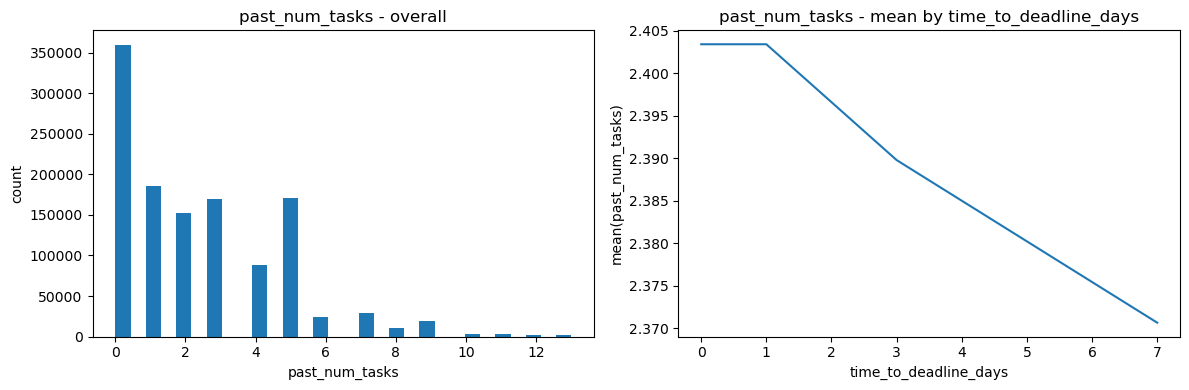

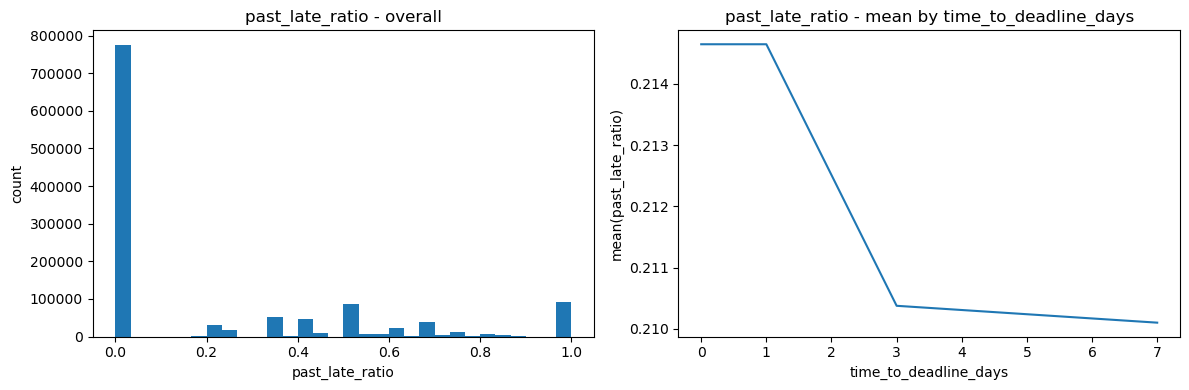

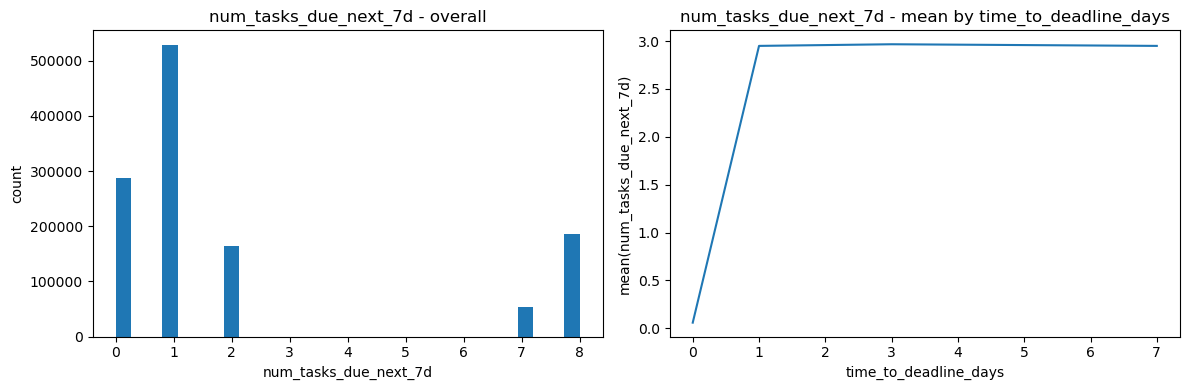

In [14]:
# 셀 3: 수치형 feature EDA 함수

def plot_numeric_distribution_overall_and_time(
    df,
    col,
    time_col="time_to_deadline_days",
    bins=30
):
    """
    col: 보고 싶은 수치형 feature 이름
    time_col: 시간 축 (기본: 마감까지 남은 일수)
    """
    if col not in df.columns:
        print(f"[WARN] {col} not in df.columns")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 1) 전체 분포
    axes[0].hist(df[col].dropna(), bins=bins)
    axes[0].set_title(f"{col} - overall")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("count")

    # 2) 시간 축별 평균
    #   (time_col 은 int 로 캐스팅해서 groupby)
    tmp = (
        df[[time_col, col]]
        .dropna()
        .copy()
    )
    tmp[time_col] = tmp[time_col].astype(int)

    mean_by_time = (
        tmp.groupby(time_col)[col]
           .mean()
           .reset_index()
           .sort_values(time_col)
    )

    axes[1].plot(mean_by_time[time_col], mean_by_time[col])
    axes[1].set_title(f"{col} - mean by {time_col}")
    axes[1].set_xlabel(time_col)
    axes[1].set_ylabel(f"mean({col})")

    plt.tight_layout()
    plt.show()


# 예시: 과거 과제 수 / late 비율 / 남은 과제 수
plot_numeric_distribution_overall_and_time(df, "past_num_tasks")
plot_numeric_distribution_overall_and_time(df, "past_late_ratio")
plot_numeric_distribution_overall_and_time(df, "num_tasks_due_next_7d")


In [16]:
# 셀 5: 범주형 feature EDA 함수

def show_categorical_distribution(
    df,
    col,
    time_col="time_to_deadline_days",
    top_k=5
):
    """
    col: 범주형 feature (예: gender, age_band, highest_education)
    시간별로도 상위 카테고리 분포를 간단히 출력.
    """
    if col not in df.columns:
        print(f"[WARN] {col} not in df.columns")
        return

    print(f"=== Overall value counts for '{col}' ===")
    display(df[col].value_counts(dropna=False))

    # 시간 축 기준 상위 top_k 카테고리만 선택
    top_values = (
        df[col].value_counts().head(top_k).index.tolist()
    )

    tmp = df[df[col].isin(top_values)].copy()
    tmp[time_col] = tmp[time_col].astype(int)

    # 시간 x 카테고리 count 테이블
    ct = (
        tmp.groupby([time_col, col])
           .size()
           .reset_index(name="count")
    )

    # 시간별 total로 나눠서 비율 계산
    total_per_time = (
        ct.groupby(time_col)["count"]
          .sum()
          .reset_index()
          .rename(columns={"count": "total"})
    )
    ct = ct.merge(total_per_time, on=time_col, how="left")
    ct["ratio"] = ct["count"] / ct["total"]

    print(f"\n=== '{col}' ratio by {time_col} (top {top_k} categories) ===")
    display(ct.head(20))


# 예시: 성별 / 나이대 / 교육수준 분포
show_categorical_distribution(df, "gender", "time_to_deadline_days")
show_categorical_distribution(df, "age_band", "time_to_deadline_days")
show_categorical_distribution(df, "highest_education", "time_to_deadline_days")


=== Overall value counts for 'gender' ===


gender
M    673612
F    544776
Name: count, dtype: int64


=== 'gender' ratio by time_to_deadline_days (top 5 categories) ===


,time_to_deadline_days,gender,count,total,ratio
0,0,F,136194,304597,0.447129
1,0,M,168403,304597,0.552871
2,1,F,136194,304597,0.447129
3,1,M,168403,304597,0.552871
4,3,F,136194,304597,0.447129
5,3,M,168403,304597,0.552871
6,7,F,136194,304597,0.447129
7,7,M,168403,304597,0.552871


=== Overall value counts for 'age_band' ===


age_band
0-35     859476
35-55    352008
55<=       6904
Name: count, dtype: int64


=== 'age_band' ratio by time_to_deadline_days (top 5 categories) ===


,time_to_deadline_days,age_band,count,total,ratio
0,0,0-35,214869,304597,0.705421
1,0,35-55,88002,304597,0.288913
2,0,55<=,1726,304597,0.005667
3,1,0-35,214869,304597,0.705421
4,1,35-55,88002,304597,0.288913
5,1,55<=,1726,304597,0.005667
6,3,0-35,214869,304597,0.705421
7,3,35-55,88002,304597,0.288913
8,3,55<=,1726,304597,0.005667
9,7,0-35,214869,304597,0.705421


=== Overall value counts for 'highest_education' ===


highest_education
A Level or Equivalent          520028
Lower Than A Level             505480
HE Qualification               168512
No Formal quals                 13536
Post Graduate Qualification     10832
Name: count, dtype: int64


=== 'highest_education' ratio by time_to_deadline_days (top 5 categories) ===


,time_to_deadline_days,highest_education,count,total,ratio
0,0,A Level or Equivalent,130007,304597,0.426816
1,0,HE Qualification,42128,304597,0.138307
2,0,Lower Than A Level,126370,304597,0.414876
3,0,No Formal quals,3384,304597,0.011110
4,0,Post Graduate Qualification,2708,304597,0.008890
5,1,A Level or Equivalent,130007,304597,0.426816
6,1,HE Qualification,42128,304597,0.138307
7,1,Lower Than A Level,126370,304597,0.414876
8,1,No Formal quals,3384,304597,0.011110
9,1,Post Graduate Qualification,2708,304597,0.008890


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [34]:
df_model = df.copy()

# label (late_final) 사용
y = df_model["label_late_final"]

# id-like 컬럼 + snapshot info는 제외
drop_cols = [
    "snapshot_id", "course_id", "student_id", "task_id",
    "submitted_final", "submitted_by_snapshot",
    "label_late_final", "label_warn_H48","late_final","due_day_y","submission_day",
]
X = df_model.drop(columns=drop_cols, errors="ignore")

# 범주형 one-hot encoding
X = pd.get_dummies(X, drop_first=True)

X = X.fillna(0.0)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("\n[사용된 Feature 목록]")
features_df = pd.DataFrame({"feature": X_train.columns})
display(features_df)

Train shape: (974710, 27)
Val shape:   (243678, 27)

[사용된 Feature 목록]


,feature
0,snapshot_day
1,time_to_deadline_days
2,time_to_deadline_hours
3,due_day_x
4,history_day
5,day
6,tasks_on_day
7,late_on_day
8,submitted_on_day
9,buffer_sum_on_day


In [35]:
max_estimators = 250  # 총 트리 개수

model = GradientBoostingClassifier(
    n_estimators=1,          # 일단 1개로 시작
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    warm_start=True          # 👉 계속 이어서 트리 추가
)


[Fitting with tqdm over trees...]


Fitting trees: 100%|██████████| 250/250 [32:53<00:00,  7.89s/it]


,iter,train_loss,val_loss,train_acc,val_acc
0,1,0.658501,0.658595,0.60036,0.600362
1,2,0.646260,0.646447,0.60036,0.600362
2,3,0.634331,0.634602,0.60036,0.600362
3,4,0.623874,0.624230,0.60036,0.600362
4,5,0.613938,0.614367,0.60036,0.600362


,iter,train_loss,val_loss,train_acc,val_acc
245,246,0.393899,0.394628,0.820495,0.821079
246,247,0.393847,0.394577,0.820461,0.820989
247,248,0.393791,0.394524,0.820654,0.821272
248,249,0.393690,0.394423,0.820615,0.821190
249,250,0.393618,0.394348,0.820672,0.821178


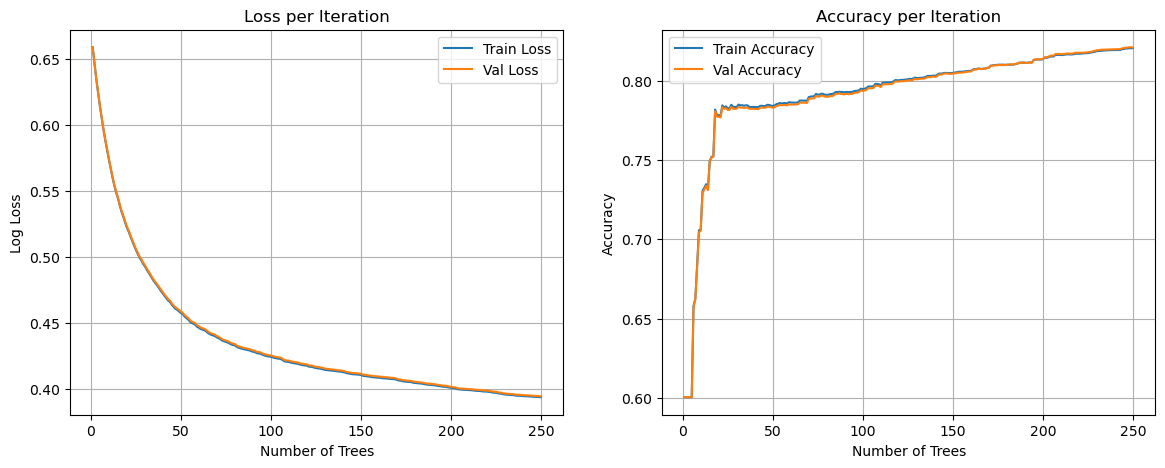

In [36]:
train_loss_list = []
val_loss_list   = []
train_acc_list  = []
val_acc_list    = []

print("\n[Fitting with tqdm over trees...]")
for n in tqdm(range(1, max_estimators + 1), desc="Fitting trees"):
    model.n_estimators = n
    model.fit(X_train, y_train)   # 이전 단계에서 이어서 트리 추가
    
    # 현재까지 학습된 모델로 평가
    proba_train = model.predict_proba(X_train)
    proba_val   = model.predict_proba(X_val)

    train_loss_list.append(log_loss(y_train, proba_train[:, 1]))
    val_loss_list.append(log_loss(y_val,   proba_val[:, 1]))

    train_pred = (proba_train[:, 1] > 0.5).astype(int)
    val_pred   = (proba_val[:, 1]   > 0.5).astype(int)

    train_acc_list.append(accuracy_score(y_train, train_pred))
    val_acc_list.append(accuracy_score(y_val,   val_pred))

# -------------------------
# 4. 표로 보기
# -------------------------

history_df = pd.DataFrame({
    "iter": np.arange(1, max_estimators + 1),
    "train_loss": train_loss_list,
    "val_loss":   val_loss_list,
    "train_acc":  train_acc_list,
    "val_acc":    val_acc_list,
})

display(history_df.head())
display(history_df.tail())

# -------------------------
# 5. 그래프 시각화
# -------------------------

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_df["iter"], history_df["train_loss"], label="Train Loss")
plt.plot(history_df["iter"], history_df["val_loss"],   label="Val Loss")
plt.title("Loss per Iteration")
plt.xlabel("Number of Trees")
plt.ylabel("Log Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_df["iter"], history_df["train_acc"], label="Train Accuracy")
plt.plot(history_df["iter"], history_df["val_acc"],   label="Val Accuracy")
plt.title("Accuracy per Iteration")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()

,feature,importance
0,due_day_x,0.347890
1,day,0.329872
2,past_avg_buffer_days,0.158108
3,cum_buffer_sum,0.042774
4,past_late_ratio,0.033296
5,past_num_tasks,0.026674
6,num_tasks_due_next_7d,0.010320
7,history_day,0.009651
8,snapshot_day,0.008280
9,studied_credits,0.007734


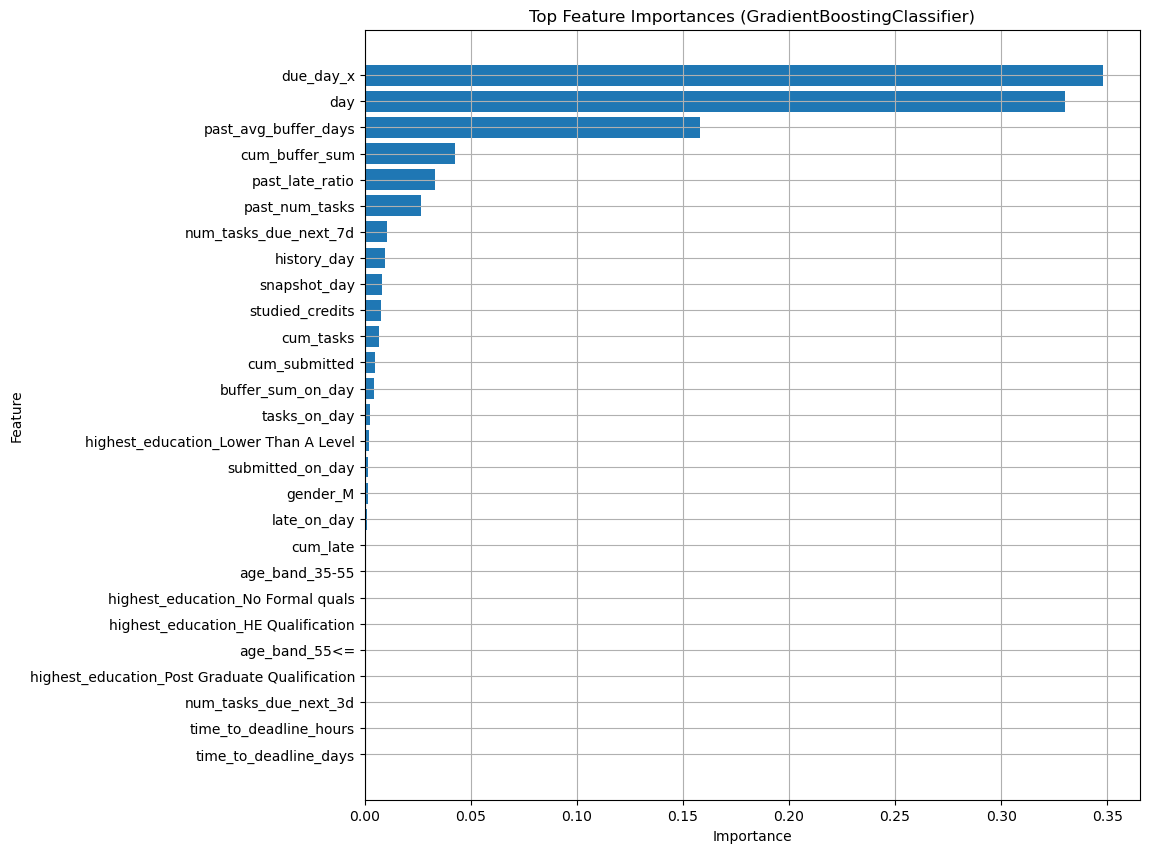

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# GradientBoostingClassifier는 feature_importances_ 제공
importances = model.feature_importances_

# feature 이름
feature_names = X_train.columns

# 정렬
indices = np.argsort(importances)[::-1]   # 중요도 높은 순서

sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# 상위 30개만 보기 (원하시면 숫자 바꿔도 됨)
TOP_K = 30
top_features = sorted_features[:TOP_K]
top_importances = sorted_importances[:TOP_K]

# 테이블로 보기
importance_df = pd.DataFrame({
    "feature": top_features,
    "importance": top_importances
})

display(importance_df)

# 그래프 그리기
plt.figure(figsize=(10, 10))
plt.barh(top_features[::-1], top_importances[::-1])  # 위에서 아래로 내림차순
plt.title("Top Feature Importances (GradientBoostingClassifier)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

In [38]:
df_model_drop_finish = df[
    (df["submission_day"].isna()) | 
    (df["snapshot_day"] < df["submission_day"])
].copy()

# label (late_final) 사용
y = df_model_drop_finish["label_late_final"]

# id-like 컬럼 + snapshot info는 제외
drop_cols = [
    "snapshot_id", "course_id", "student_id", "task_id",
    "submitted_final", "submitted_by_snapshot",
    "label_late_final", "label_warn_H48","late_final","due_day_y","submission_day",
]
X = df_model_drop_finish.drop(columns=drop_cols, errors="ignore")

# 범주형 one-hot encoding
X = pd.get_dummies(X, drop_first=True)

X = X.fillna(0.0)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("\n[사용된 Feature 목록]")
features_df = pd.DataFrame({"feature": X_train.columns})
display(features_df)

Train shape: (724702, 27)
Val shape:   (181176, 27)

[사용된 Feature 목록]


,feature
0,snapshot_day
1,time_to_deadline_days
2,time_to_deadline_hours
3,due_day_x
4,history_day
5,day
6,tasks_on_day
7,late_on_day
8,submitted_on_day
9,buffer_sum_on_day


In [39]:
max_estimators = 250  # 총 트리 개수

model = GradientBoostingClassifier(
    n_estimators=1,          # 일단 1개로 시작
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    warm_start=True          # 👉 계속 이어서 트리 추가
)


[Fitting with tqdm over trees...]


Fitting trees: 100%|██████████| 250/250 [25:15<00:00,  6.06s/it]


,iter,train_loss,val_loss,train_acc,val_acc
0,1,0.479837,0.479927,0.807473,0.807474
1,2,0.470945,0.471114,0.807473,0.807474
2,3,0.461957,0.462165,0.807473,0.807474
3,4,0.454587,0.454866,0.807473,0.807474
4,5,0.447033,0.447346,0.807473,0.807474


,iter,train_loss,val_loss,train_acc,val_acc
245,246,0.262041,0.263066,0.875114,0.873852
246,247,0.261993,0.263025,0.875167,0.873896
247,248,0.261858,0.262898,0.875171,0.873957
248,249,0.261733,0.262771,0.875161,0.873957
249,250,0.261659,0.262697,0.875171,0.873973


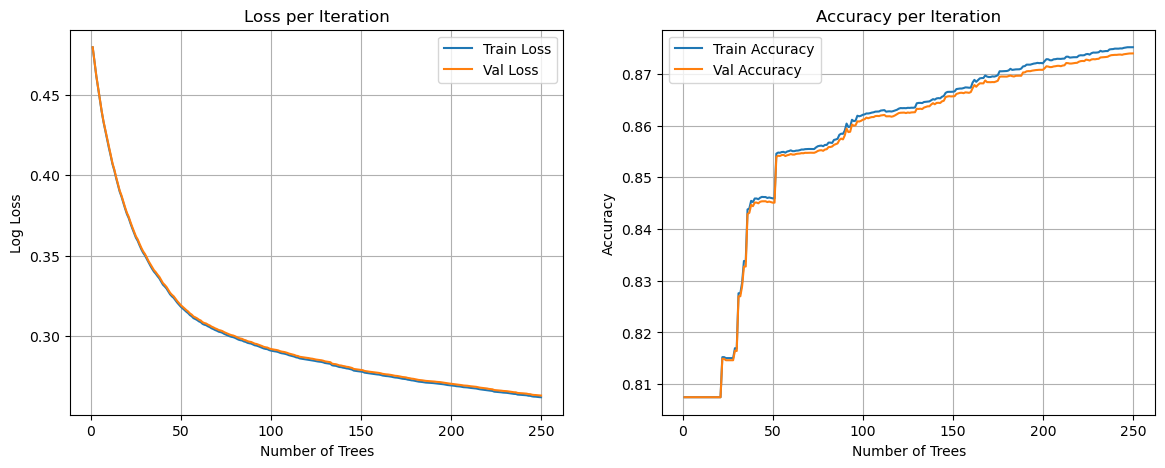

In [40]:
train_loss_list = []
val_loss_list   = []
train_acc_list  = []
val_acc_list    = []

print("\n[Fitting with tqdm over trees...]")
for n in tqdm(range(1, max_estimators + 1), desc="Fitting trees"):
    model.n_estimators = n
    model.fit(X_train, y_train)   # 이전 단계에서 이어서 트리 추가
    
    # 현재까지 학습된 모델로 평가
    proba_train = model.predict_proba(X_train)
    proba_val   = model.predict_proba(X_val)

    train_loss_list.append(log_loss(y_train, proba_train[:, 1]))
    val_loss_list.append(log_loss(y_val,   proba_val[:, 1]))

    train_pred = (proba_train[:, 1] > 0.5).astype(int)
    val_pred   = (proba_val[:, 1]   > 0.5).astype(int)

    train_acc_list.append(accuracy_score(y_train, train_pred))
    val_acc_list.append(accuracy_score(y_val,   val_pred))

# -------------------------
# 4. 표로 보기
# -------------------------

history_df = pd.DataFrame({
    "iter": np.arange(1, max_estimators + 1),
    "train_loss": train_loss_list,
    "val_loss":   val_loss_list,
    "train_acc":  train_acc_list,
    "val_acc":    val_acc_list,
})

display(history_df.head())
display(history_df.tail())

# -------------------------
# 5. 그래프 시각화
# -------------------------

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_df["iter"], history_df["train_loss"], label="Train Loss")
plt.plot(history_df["iter"], history_df["val_loss"],   label="Val Loss")
plt.title("Loss per Iteration")
plt.xlabel("Number of Trees")
plt.ylabel("Log Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_df["iter"], history_df["train_acc"], label="Train Accuracy")
plt.plot(history_df["iter"], history_df["val_acc"],   label="Val Accuracy")
plt.title("Accuracy per Iteration")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()

,feature,importance
0,day,0.230083
1,due_day_x,0.157616
2,time_to_deadline_days,0.103230
3,time_to_deadline_hours,0.099267
4,past_avg_buffer_days,0.091411
5,snapshot_day,0.082566
6,history_day,0.078592
7,num_tasks_due_next_7d,0.049949
8,past_late_ratio,0.042719
9,num_tasks_due_next_3d,0.014760


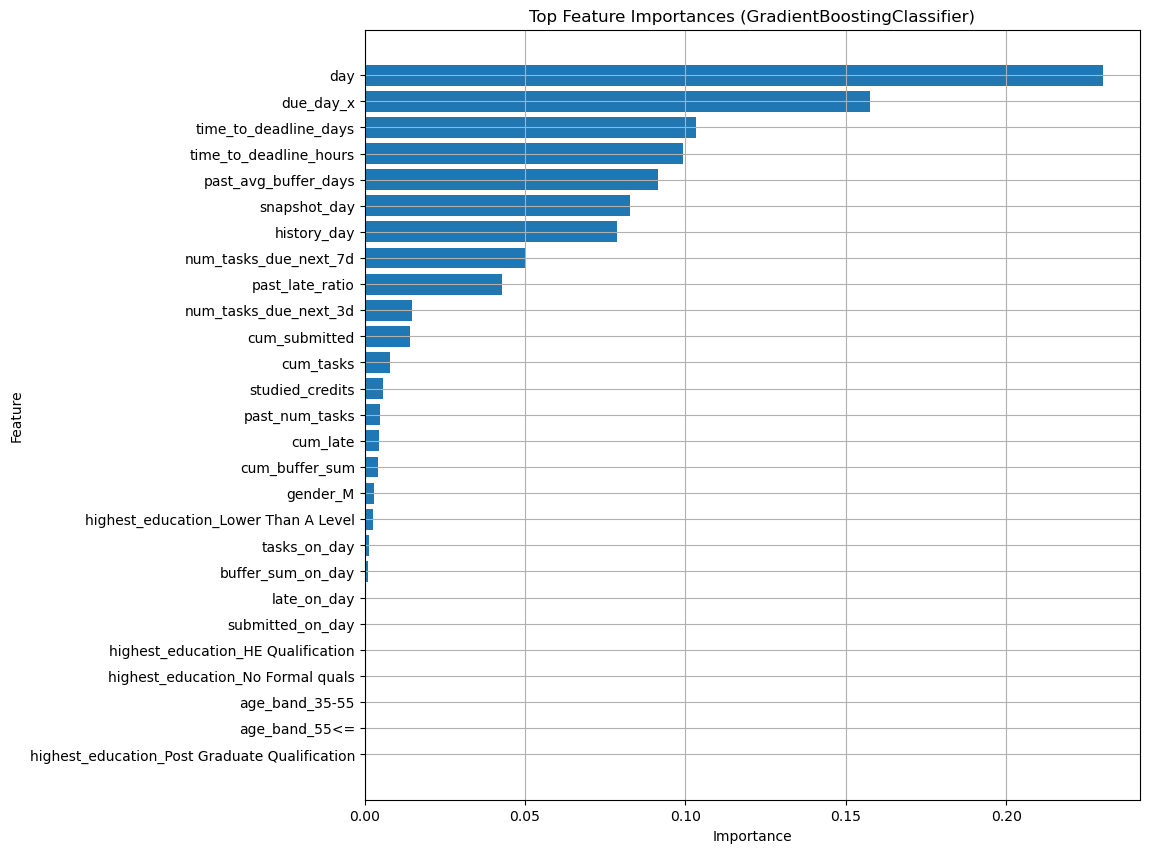

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# GradientBoostingClassifier는 feature_importances_ 제공
importances = model.feature_importances_

# feature 이름
feature_names = X_train.columns

# 정렬
indices = np.argsort(importances)[::-1]   # 중요도 높은 순서

sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# 상위 30개만 보기 (원하시면 숫자 바꿔도 됨)
TOP_K = 30
top_features = sorted_features[:TOP_K]
top_importances = sorted_importances[:TOP_K]

# 테이블로 보기
importance_df = pd.DataFrame({
    "feature": top_features,
    "importance": top_importances
})

display(importance_df)

# 그래프 그리기
plt.figure(figsize=(10, 10))
plt.barh(top_features[::-1], top_importances[::-1])  # 위에서 아래로 내림차순
plt.title("Top Feature Importances (GradientBoostingClassifier)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

df_model_risk shape: (905878, 38)

[Risk 모델용 Feature 학습 데이터 크기]
Train shape: (724702, 31)
Val shape:   (181176, 31)

[Risk 모델에서 사용된 Feature 목록]


,feature
0,snapshot_day
1,time_to_deadline_days
2,time_to_deadline_hours
3,due_day_x
4,history_day
5,day
6,tasks_on_day
7,late_on_day
8,submitted_on_day
9,buffer_sum_on_day



[Fitting RISK 모델 with tqdm over trees...]


Fitting trees (risk): 100%|██████████| 250/250 [25:23<00:00,  6.09s/it]


[RISK 모델 학습 history (head)]


,iter,train_loss,val_loss,train_acc,val_acc
0,1,0.479837,0.479927,0.807473,0.807474
1,2,0.470945,0.471114,0.807473,0.807474
2,3,0.461957,0.462165,0.807473,0.807474
3,4,0.454587,0.454866,0.807473,0.807474
4,5,0.447033,0.447346,0.807473,0.807474



[RISK 모델 학습 history (tail)]


,iter,train_loss,val_loss,train_acc,val_acc
245,246,0.262548,0.263589,0.875131,0.874029
246,247,0.262469,0.263518,0.875164,0.874012
247,248,0.262089,0.263136,0.875229,0.874156
248,249,0.262041,0.263085,0.875220,0.874156
249,250,0.261968,0.263012,0.875260,0.874189


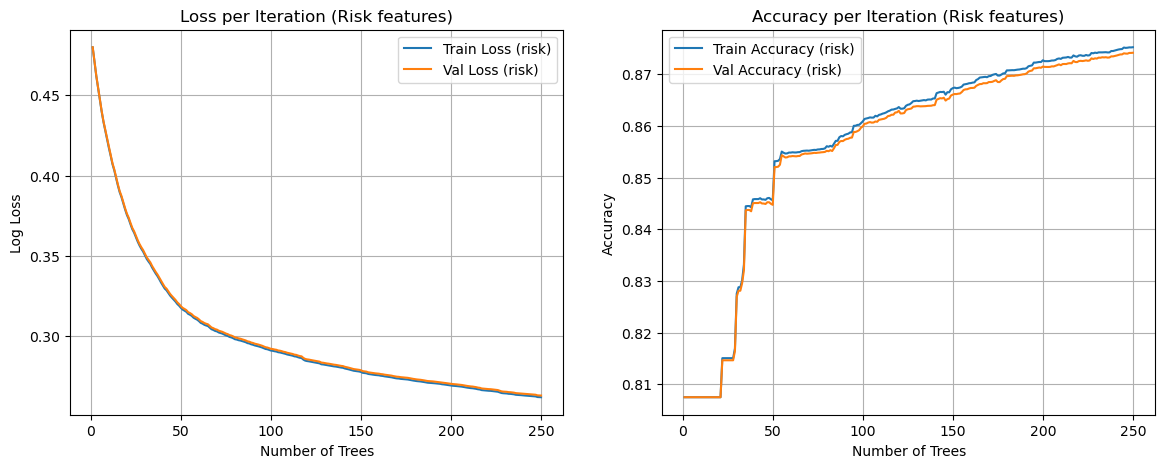


[RISK 모델 Feature Importances 상위 30개]


,feature,importance
0,day,0.225666
1,due_day_x,0.153624
2,past_avg_buffer_days,0.095473
3,history_day,0.085147
4,snapshot_day,0.082381
5,time_to_deadline_hours,0.075112
6,urgency,0.057334
7,num_tasks_due_next_7d,0.050378
8,days_left,0.036685
9,time_to_deadline_days,0.029479


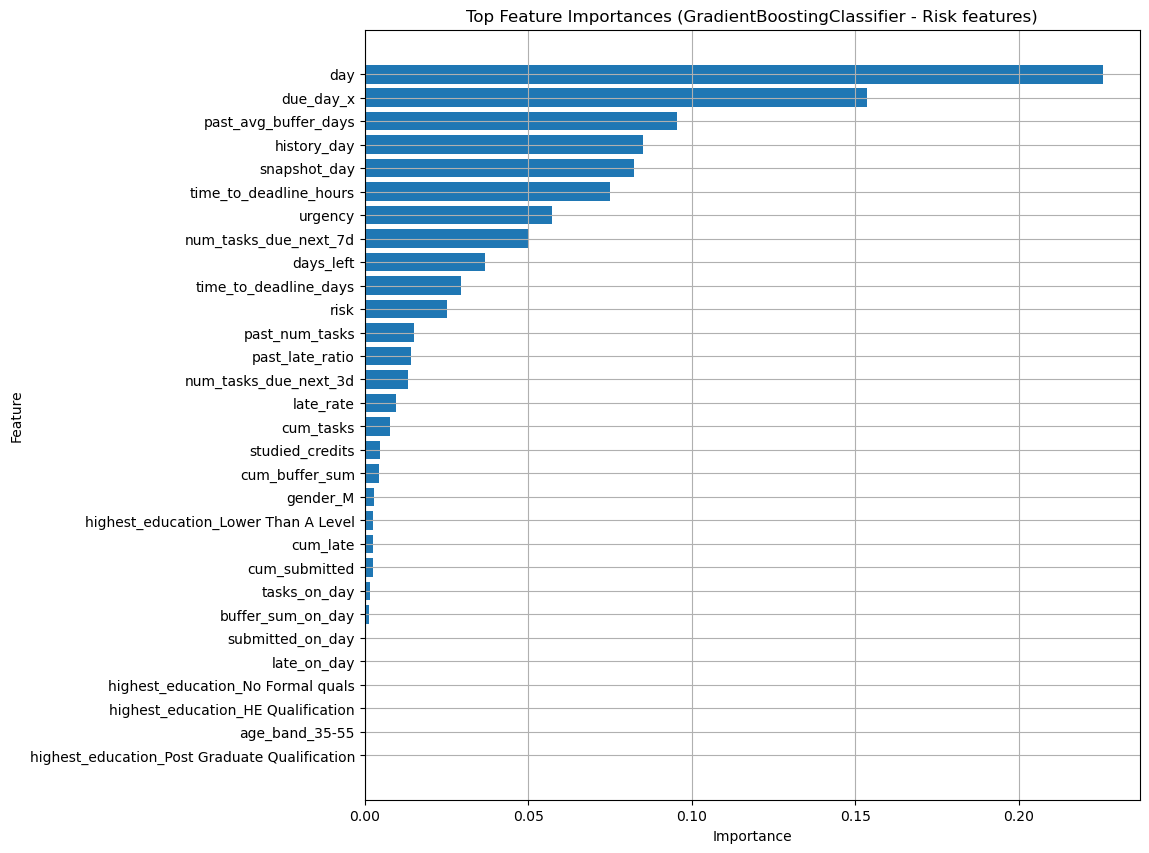

In [42]:
# ============================================
#  새로운 feature (late_rate, urgency, risk) 추가 버전
#  기존 결과와 안 겹치게 _risk suffix로 분리
# ============================================

# 1) 새로운 feature 추가한 df 만들기
df_model_risk = df_model_drop_finish.copy()

# snapshot-safe late_rate: 이미 있는 past_late_ratio를 late_rate로 사용
df_model_risk["late_rate"] = df_model_risk["past_late_ratio"].fillna(0.0)

# days_left: time_to_deadline_days (0일은 1로 클립해서 division 방지)
df_model_risk["days_left"] = df_model_risk["time_to_deadline_days"].clip(lower=1)

# urgency: 마감이 가까울수록 큰 값 (1 / days_left)
df_model_risk["urgency"] = 1.0 / df_model_risk["days_left"]

# risk: 평소 지각 성향 × 현재 과제의 긴급도
df_model_risk["risk"] = df_model_risk["late_rate"] * df_model_risk["urgency"]

print("df_model_risk shape:", df_model_risk.shape)
df_model_risk[["late_rate", "days_left", "urgency", "risk"]].head()

# 2) label & X_risk 만들기 (기존 drop_cols 재사용 + 이름만 다르게)
y_risk = df_model_risk["label_late_final"]

drop_cols_risk = [
    "snapshot_id", "course_id", "student_id", "task_id",
    "submitted_final", "submitted_by_snapshot",
    "label_late_final", "label_warn_H48", "late_final",
    "due_day_y", "submission_day",
    # days_left는 feature로 쓸 거라서 일부러 안 뺍니다
]

X_risk = df_model_risk.drop(columns=drop_cols_risk, errors="ignore")

# one-hot 인코딩 + NaN 처리
X_risk = pd.get_dummies(X_risk, drop_first=True)
X_risk = X_risk.fillna(0.0)

# train/test split (random_state 동일하게 해서 비교 가능)
X_risk_train, X_risk_val, y_risk_train, y_risk_val = train_test_split(
    X_risk, y_risk, test_size=0.2, random_state=42, stratify=y_risk
)

print("\n[Risk 모델용 Feature 학습 데이터 크기]")
print("Train shape:", X_risk_train.shape)
print("Val shape:  ", X_risk_val.shape)

print("\n[Risk 모델에서 사용된 Feature 목록]")
display(pd.DataFrame({"feature": X_risk_train.columns}))

# 3) GradientBoosting (warm_start)로 iter별 학습 + tqdm
max_estimators_risk = 250

model_risk = GradientBoostingClassifier(
    n_estimators=1,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    warm_start=True,
)

train_loss_list_risk = []
val_loss_list_risk   = []
train_acc_list_risk  = []
val_acc_list_risk    = []

print("\n[Fitting RISK 모델 with tqdm over trees...]")
for n in tqdm(range(1, max_estimators_risk + 1), desc="Fitting trees (risk)"):
    model_risk.n_estimators = n
    model_risk.fit(X_risk_train, y_risk_train)

    proba_train = model_risk.predict_proba(X_risk_train)
    proba_val   = model_risk.predict_proba(X_risk_val)

    train_loss_list_risk.append(log_loss(y_risk_train, proba_train[:, 1]))
    val_loss_list_risk.append(log_loss(y_risk_val,   proba_val[:, 1]))

    train_pred = (proba_train[:, 1] > 0.5).astype(int)
    val_pred   = (proba_val[:, 1]   > 0.5).astype(int)

    train_acc_list_risk.append(accuracy_score(y_risk_train, train_pred))
    val_acc_list_risk.append(accuracy_score(y_risk_val,   val_pred))

# 4) history_df_risk 표로 보기
history_df_risk = pd.DataFrame({
    "iter": np.arange(1, max_estimators_risk + 1),
    "train_loss": train_loss_list_risk,
    "val_loss":   val_loss_list_risk,
    "train_acc":  train_acc_list_risk,
    "val_acc":    val_acc_list_risk,
})

print("\n[RISK 모델 학습 history (head)]")
display(history_df_risk.head())
print("\n[RISK 모델 학습 history (tail)]")
display(history_df_risk.tail())

# 5) 그래프 시각화 (기존이랑 안 겹치게 제목만 다르게)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_df_risk["iter"], history_df_risk["train_loss"], label="Train Loss (risk)")
plt.plot(history_df_risk["iter"], history_df_risk["val_loss"],   label="Val Loss (risk)")
plt.title("Loss per Iteration (Risk features)")
plt.xlabel("Number of Trees")
plt.ylabel("Log Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_df_risk["iter"], history_df_risk["train_acc"], label="Train Accuracy (risk)")
plt.plot(history_df_risk["iter"], history_df_risk["val_acc"],   label="Val Accuracy (risk)")
plt.title("Accuracy per Iteration (Risk features)")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()

# 6) Feature Importance (RISK 모델용)
importances_risk = model_risk.feature_importances_
feature_names_risk = X_risk_train.columns

indices_risk = np.argsort(importances_risk)[::-1]
sorted_features_risk = feature_names_risk[indices_risk]
sorted_importances_risk = importances_risk[indices_risk]

TOP_K = 30
top_features_risk = sorted_features_risk[:TOP_K]
top_importances_risk = sorted_importances_risk[:TOP_K]

importance_df_risk = pd.DataFrame({
    "feature": top_features_risk,
    "importance": top_importances_risk
})

print("\n[RISK 모델 Feature Importances 상위 30개]")
display(importance_df_risk)

plt.figure(figsize=(10, 10))
plt.barh(top_features_risk[::-1], top_importances_risk[::-1])
plt.title("Top Feature Importances (GradientBoostingClassifier - Risk features)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


In [43]:
# ============================================
#  RISK 버전 GradientBoosting 간단 하이퍼파라미터 탐색
#  - 몇 가지 조합만 테스트 (learning_rate, max_depth, subsample)
#  - 각 조합마다 iter별 loss/acc 그래프를 파일로 저장
#  - 요약 테이블로 best 조합 확인
# ============================================

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import os

# 1) 테스트할 하이퍼파라미터 후보들 (간단하게 몇 개)
learning_rates = [0.03, 0.05, 0.1]
max_depths     = [2, 3]
subsamples     = [0.8, 1.0]

max_estimators_hp = 200   # 트리 개수 (조금 줄여서 탐색 속도 확보)

# 그래프 저장 폴더
FIG_DIR = "figs_gb_risk"
os.makedirs(FIG_DIR, exist_ok=True)

results_summary = []   # 각 조합의 best 성능을 저장할 리스트

# 2) 모든 조합에 대해 loop (간단한 grid 탐색 느낌 + greedy 참고용)
for lr, depth, subs in product(learning_rates, max_depths, subsamples):
    print(f"\n===== Config: lr={lr}, max_depth={depth}, subsample={subs} =====")

    # 모델 초기화 (매 조합마다 새 모델)
    model_hp = GradientBoostingClassifier(
        n_estimators=1,          # warm_start로 1→max_estimators_hp까지 늘려감
        learning_rate=lr,
        max_depth=depth,
        subsample=subs,
        random_state=42,
        warm_start=True,
    )

    train_loss_hist = []
    val_loss_hist   = []
    train_acc_hist  = []
    val_acc_hist    = []

    # tqdm으로 iter 진행 상황 표시
    for n in tqdm(range(1, max_estimators_hp + 1), desc=f"Fitting trees (lr={lr}, d={depth}, sub={subs})"):
        model_hp.n_estimators = n
        model_hp.fit(X_risk_train, y_risk_train)

        proba_tr = model_hp.predict_proba(X_risk_train)
        proba_vl = model_hp.predict_proba(X_risk_val)

        # loss
        train_loss_hist.append(log_loss(y_risk_train, proba_tr[:, 1]))
        val_loss_hist.append(log_loss(y_risk_val,   proba_vl[:, 1]))

        # acc
        pred_tr = (proba_tr[:, 1] > 0.5).astype(int)
        pred_vl = (proba_vl[:, 1] > 0.5).astype(int)
        train_acc_hist.append(accuracy_score(y_risk_train, pred_tr))
        val_acc_hist.append(accuracy_score(y_risk_val,   pred_vl))

    # history dataframe
    history_hp = pd.DataFrame({
        "iter": np.arange(1, max_estimators_hp + 1),
        "train_loss": train_loss_hist,
        "val_loss":   val_loss_hist,
        "train_acc":  train_acc_hist,
        "val_acc":    val_acc_hist,
    })

    # 이 조합에서 best val_loss / val_acc 기준 요약 기록
    best_idx_loss = history_hp["val_loss"].idxmin()
    best_row_loss = history_hp.loc[best_idx_loss]

    best_idx_acc = history_hp["val_acc"].idxmax()
    best_row_acc = history_hp.loc[best_idx_acc]

    results_summary.append({
        "learning_rate": lr,
        "max_depth": depth,
        "subsample": subs,
        "best_iter_val_loss": int(best_row_loss["iter"]),
        "best_val_loss": float(best_row_loss["val_loss"]),
        "best_iter_val_acc": int(best_row_acc["iter"]),
        "best_val_acc": float(best_row_acc["val_acc"]),
    })

    # 3) 그래프 그려서 저장
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss 그래프
    axes[0].plot(history_hp["iter"], history_hp["train_loss"], label="Train Loss")
    axes[0].plot(history_hp["iter"], history_hp["val_loss"],   label="Val Loss")
    axes[0].set_title(f"Loss (lr={lr}, depth={depth}, sub={subs})")
    axes[0].set_xlabel("Number of Trees")
    axes[0].set_ylabel("Log Loss")
    axes[0].grid(True)
    axes[0].legend()

    # Accuracy 그래프
    axes[1].plot(history_hp["iter"], history_hp["train_acc"], label="Train Acc")
    axes[1].plot(history_hp["iter"], history_hp["val_acc"],   label="Val Acc")
    axes[1].set_title(f"Accuracy (lr={lr}, depth={depth}, sub={subs})")
    axes[1].set_xlabel("Number of Trees")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()

    # 파일 이름에 하이퍼파라미터 표시 (점 대신 p로 치환)
    fname = f"gb_risk_lr{str(lr).replace('.', 'p')}_d{depth}_sub{str(subs).replace('.', 'p')}.png"
    save_path = os.path.join(FIG_DIR, fname)
    plt.savefig(save_path, bbox_inches="tight")
    plt.close(fig)

    print(f"→ 그래프 저장: {save_path}")

# 4) 모든 조합에 대한 요약 테이블
summary_df = pd.DataFrame(results_summary)
print("\n=== Hyperparameter Search Summary (정렬: best_val_loss 기준) ===")
display(summary_df.sort_values("best_val_loss"))

print("\n=== Hyperparameter Search Summary (정렬: best_val_acc 기준) ===")
display(summary_df.sort_values("best_val_acc", ascending=False))



===== Config: lr=0.03, max_depth=2, subsample=0.8 =====


Fitting trees (lr=0.03, d=2, sub=0.8): 100%|██████████| 200/200 [14:01<00:00,  4.21s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p03_d2_sub0p8.png

===== Config: lr=0.03, max_depth=2, subsample=1.0 =====


Fitting trees (lr=0.03, d=2, sub=1.0): 100%|██████████| 200/200 [14:57<00:00,  4.49s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p03_d2_sub1p0.png

===== Config: lr=0.03, max_depth=3, subsample=0.8 =====


Fitting trees (lr=0.03, d=3, sub=0.8): 100%|██████████| 200/200 [18:50<00:00,  5.65s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p03_d3_sub0p8.png

===== Config: lr=0.03, max_depth=3, subsample=1.0 =====


Fitting trees (lr=0.03, d=3, sub=1.0): 100%|██████████| 200/200 [20:16<00:00,  6.08s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p03_d3_sub1p0.png

===== Config: lr=0.05, max_depth=2, subsample=0.8 =====


Fitting trees (lr=0.05, d=2, sub=0.8): 100%|██████████| 200/200 [13:43<00:00,  4.12s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p05_d2_sub0p8.png

===== Config: lr=0.05, max_depth=2, subsample=1.0 =====


Fitting trees (lr=0.05, d=2, sub=1.0): 100%|██████████| 200/200 [14:38<00:00,  4.39s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p05_d2_sub1p0.png

===== Config: lr=0.05, max_depth=3, subsample=0.8 =====


Fitting trees (lr=0.05, d=3, sub=0.8): 100%|██████████| 200/200 [18:13<00:00,  5.47s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p05_d3_sub0p8.png

===== Config: lr=0.05, max_depth=3, subsample=1.0 =====


Fitting trees (lr=0.05, d=3, sub=1.0): 100%|██████████| 200/200 [19:42<00:00,  5.91s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p05_d3_sub1p0.png

===== Config: lr=0.1, max_depth=2, subsample=0.8 =====


Fitting trees (lr=0.1, d=2, sub=0.8): 100%|██████████| 200/200 [13:23<00:00,  4.02s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p1_d2_sub0p8.png

===== Config: lr=0.1, max_depth=2, subsample=1.0 =====


Fitting trees (lr=0.1, d=2, sub=1.0): 100%|██████████| 200/200 [14:20<00:00,  4.30s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p1_d2_sub1p0.png

===== Config: lr=0.1, max_depth=3, subsample=0.8 =====


Fitting trees (lr=0.1, d=3, sub=0.8): 100%|██████████| 200/200 [17:22<00:00,  5.21s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p1_d3_sub0p8.png

===== Config: lr=0.1, max_depth=3, subsample=1.0 =====


Fitting trees (lr=0.1, d=3, sub=1.0): 100%|██████████| 200/200 [18:54<00:00,  5.67s/it]


→ 그래프 저장: figs_gb_risk\gb_risk_lr0p1_d3_sub1p0.png

=== Hyperparameter Search Summary (정렬: best_val_loss 기준) ===


,learning_rate,max_depth,subsample,best_iter_val_loss,best_val_loss,best_iter_val_acc,best_val_acc
11,0.10,3,1.0,200,0.251134,200,0.878957
10,0.10,3,0.8,200,0.251661,200,0.878847
7,0.05,3,1.0,200,0.270032,200,0.871683
6,0.05,3,0.8,200,0.270269,200,0.871517
9,0.10,2,1.0,200,0.276616,197,0.869381
8,0.10,2,0.8,200,0.276634,197,0.869089
2,0.03,3,0.8,200,0.285522,200,0.864243
3,0.03,3,1.0,200,0.286670,193,0.861963
4,0.05,2,0.8,200,0.295172,188,0.860561
5,0.05,2,1.0,200,0.295666,199,0.861687



=== Hyperparameter Search Summary (정렬: best_val_acc 기준) ===


,learning_rate,max_depth,subsample,best_iter_val_loss,best_val_loss,best_iter_val_acc,best_val_acc
11,0.10,3,1.0,200,0.251134,200,0.878957
10,0.10,3,0.8,200,0.251661,200,0.878847
7,0.05,3,1.0,200,0.270032,200,0.871683
6,0.05,3,0.8,200,0.270269,200,0.871517
9,0.10,2,1.0,200,0.276616,197,0.869381
8,0.10,2,0.8,200,0.276634,197,0.869089
2,0.03,3,0.8,200,0.285522,200,0.864243
3,0.03,3,1.0,200,0.286670,193,0.861963
5,0.05,2,1.0,200,0.295666,199,0.861687
4,0.05,2,0.8,200,0.295172,188,0.860561


In [44]:
print("=== label_late_final 분포 (0=정상, 1=지각/미제출) ===")
print(df_snap["label_late_final"].value_counts().sort_index())
print("\n비율(%)")
print((df_snap["label_late_final"].value_counts(normalize=True).sort_index() * 100).round(2))

=== label_late_final 분포 (0=정상, 1=지각/미제출) ===
label_late_final
0    486916
1    731472
Name: count, dtype: int64

비율(%)
label_late_final
0    39.96
1    60.04
Name: proportion, dtype: float64
